# Autoencoders

In [1]:
%load_ext lab_black

In [2]:
%load_ext autoreload
%autoreload 2

In [43]:
import pickle, gzip, math, os, time, shutil, torch, matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial

from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset, load_dataset_builder

from fastprogress import progress_bar, master_bar

import logging
from fastcore.test import test_close

from cmn_ai.utils.data import *
from cmn_ai.utils.plot import *
from cmn_ai.utils.metrics import *

# from miniai.datasets import *
# from miniai.training import *
# from miniai.conv import *

In [4]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams["image.cmap"] = "gray"
logging.disable(logging.WARNING)

## Data

In [5]:
x, y = "image", "label"
name = "fashion_mnist"
dsd = load_dataset(name, ignore_verifications=True)

/Users/imad/mambaforge/envs/dl/lib/python3.11/site-packages/datasets/load.py:1744: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
def inplace(f):
    def _f(batch):
        f(batch)
        return batch

    return _f

In [7]:
@inplace
def transformi(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]

In [8]:
bs = 256
tds = dsd.with_transform(transformi)

<Axes: >

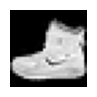

In [9]:
ds = tds["train"]
img = ds[0]["image"]
show_image(img, figsize=(1, 1))

In [10]:
cf = collate_dict(ds)

In [30]:
def_device = (
    "mps"  # for MacOs
    # if torch.backends.mps.is_available()
    # else "cuda"
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)


def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor):
        return x.to(device)
    if isinstance(x, Mapping):
        return {k: v.to(device) for k, v in x.items()}
    return type(x)(to_device(o, device) for o in x)


def collate_device(b):
    return to_device(default_collate(b))

In [31]:
def collate_(b):
    # return to_device(cf(b))
    return cf(b)


def data_loaders(dsd, bs, **kwargs):
    return {k: DataLoader(v, bs, **kwargs) for k, v in dsd.items()}

In [32]:
dls = data_loaders(tds, bs, collate_fn=collate_)

In [33]:
dt = dls["train"]
dv = dls["test"]

xb, yb = next(iter(dt))

In [34]:
labels = ds.features[y].names

In [35]:
labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [36]:
lbl_getter = itemgetter(*yb[:16])
titles = lbl_getter(labels)

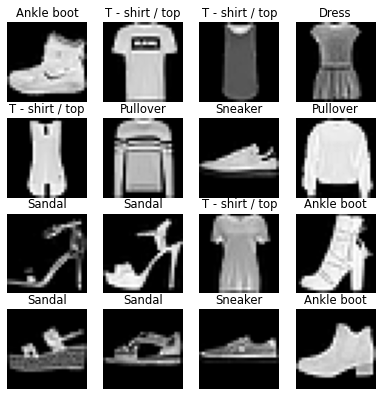

In [37]:
mpl.rcParams["figure.dpi"] = 70
show_images(xb[:16], imsize=1.7, titles=titles)

## Warmup - classify

In [38]:
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks // 2)
    if act:
        res = nn.Sequential(res, nn.ReLU())
    return res

In [39]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc, count = 0.0, 0.0, 0
            for xb, yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred, yb).item() * n
                tot_acc += accuracy(pred, yb).item() * n
        print(epoch, tot_loss / count, tot_acc / count)
    return tot_loss / count, tot_acc / count

In [40]:
bs = 256
lr = 0.4

In [41]:
cnn = nn.Sequential(
    conv(1, 4),  # 14x14
    conv(4, 8),  # 7x7
    conv(8, 16),  # 4x4
    conv(16, 16),  # 2x2
    conv(16, 10, act=False),
    nn.Flatten(),
).to(def_device)

In [44]:
opt = optim.SGD(cnn.parameters(), lr=lr)
loss, acc = fit(5, cnn, F.cross_entropy, opt, dt, dv)

0 0.5476446155548096 0.8057
1 0.5082058697938919 0.8183
2 0.43605049226284026 0.8431
3 0.4236174604415894 0.8484
4 0.3986876050949097 0.8561


In [45]:
dsd["train"][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

The reason the training is slow is that each image is stored as `PIL.Image` which means it has to be decoded before loading it to memory. We can solve this issue by storing the images as tensors.

## Autoencoder

Taking an image as input and try to out the same image after going through multi CNN layers.

In [47]:
def deconv(ni, nf, ks=3, act=True):
    layers = [
        nn.UpsamplingNearest2d(
            scale_factor=2
        ),  # Increase the size of H & W by the scale_factor
        nn.Conv2d(ni, nf, stride=1, kernel_size=ks, padding=ks // 2),
    ]
    if act:
        layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [48]:
def eval(model, loss_func, valid_dl, epoch=0):
    model.eval()
    with torch.no_grad():
        tot_loss, count = 0.0, 0
        for xb, _ in valid_dl:
            pred = model(xb)
            n = len(xb)
            count += n
            tot_loss += loss_func(pred, xb).item() * n
    print(epoch, f"{tot_loss/count:.3f}")

In [49]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, _ in train_dl:
            loss = loss_func(model(xb), xb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        eval(model, loss_func, valid_dl, epoch)

In [50]:
auto_encoder = nn.Sequential(  # 28x28
    nn.ZeroPad2d(2),  # 32x32
    conv(1, 2),  # 16x16
    conv(2, 4),  # 8x8
    #     conv(4,8),        #4x4
    #     deconv(8,4),      #8x8
    deconv(4, 2),  # 16x16
    deconv(2, 1, act=False),  # 32x32
    nn.ZeroPad2d(-2),  # 28x28
    nn.Sigmoid(),
).to(def_device)

In [52]:
eval(auto_encoder, F.mse_loss, dv)

0 0.161


In [55]:
opt = optim.SGD(auto_encoder.parameters(), lr=0.01)
fit(5, auto_encoder, F.mse_loss, opt, dt, dv)

0 0.143
1 0.134
2 0.130
3 0.128
4 0.126


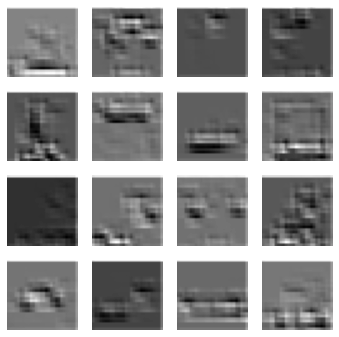

In [57]:
p = auto_encoder(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

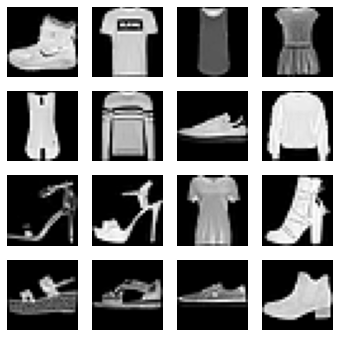

In [58]:
show_images(xb[:16].data.cpu(), imsize=1.5)

The encoder is not doing a very good job in returning back the original image that was passed as input. The compression rate is not good.